In [1]:
import numpy as np
import pandas as pd
import networkx as nx

In [2]:
from docopt import docopt
from matplotlib import pyplot as plt
from paper_reviewer_matcher import (
    linprog,
    preprocess,
    compute_affinity,
    create_lp_matrix,
    create_assignment,
    perform_mindmatch,
    compute_conflicts,
)

Using Google ortools library for ILP solver.


In [3]:
def perform_mindmatch(
    A: np.array, n_trim: int = None,
    n_match: int = 6, cois: list = None
):
    """
    Perform mindmatching with a given matrix A,
    trimming of n_trim (reduce problem size),
    matching between n_match people
    """
    # setting distance in the diagonal
    A[np.arange(len(A)), np.arange(len(A))] = -1000 

    # # if conflict of interest (COIs) is available, add to the matrix
    # cois = [(c1, c2) for (c1, c2) in cois
    #         if c1 <= len(A) and c2 <= len(A)] # make sure a given cois is in range
    # A[np.array(cois)] = -1000

    # trimming affinity matrix to reduce the problem size
    if n_trim != 0:
        A_trim = []
        for r in range(len(A)):
            a = A[r, :]
            a[np.argsort(a)[0:n_trim]] = 0
            A_trim.append(a)
        A_trim = np.vstack(A_trim)
    else:
        A_trim = A

    # solving matching problem
    print('Solving a matching problem...')
    v, K, d = create_lp_matrix(A_trim, 
                               min_reviewers_per_paper=n_match, max_reviewers_per_paper=n_match,
                               min_papers_per_reviewer=n_match, max_papers_per_reviewer=n_match)
    x_sol = linprog(v, K, d)['x']
    b = create_assignment(x_sol, A_trim)

    if (b.sum() == 0):
        print('Seems like the problem does not converge, try reducing <n_trim> but not too low!')
    else:
        print('Successfully assigned all the match!')
    return b


In [4]:
excel = pd.read_excel("data/Bayreuth Digital Science Conference_Abstracts.xlsx", sheet_name="Grouping")

In [5]:
excel

,Author,Title,Abstract,Keywords,Topic,Subtopic,subsubtopic,Group,ID
0,"Myura Nagendran, Anthony Gordon, A. Aldo Faisal",Impact of XAI dose suggestions on the prescrip...,\nBackground. \nOur AI Clinician reinforcement...,AI Clinician\n Reinforcement learning\n...,Digital Healthcare,NaN,NaN,DHFC,1
1,"Qamar El Kotob, Matthieu Komorowski, A. Aldo F...",A Secure Web Application for Evaluating the Sa...,Sepsis is a life-threatening condition that ca...,"sepsis, life-threatening condition, infection,...",Digital Healthcare,NaN,NaN,DHFC,2
2,"Benjamin Post, Roman Klapaukh, Stephen Brett, ...",AI-Captured Patient Trajectories: Harnessing E...,Emergency hospital admissions are straining he...,"Emergency hospital admissions, healthcare reco...",Digital Healthcare,ML,NaN,DHFC,3
3,"Paul Festor, Myura Nagengran, A. Aldo Faisal, ...",Safety assessment of reinforcement learning in...,Promising results have been shown on AI-based ...,"AI-based decision support systems, reinforceme...",Digital Healthcare,ML,RL,DHFC,4
4,"Fabio S Ferreira, Suniyah Minhas, James M Flan...",Data-derived digital twins for the discovery o...,Early cancer prevention and diagnostics are ty...,"early cancer prevention, diagnostics, clinical...",Digital Healthcare,ML,NaN,DHFC,5
...,...,...,...,...,...,...,...,...,...
90,"Viktorija Paneva, Arthur Fleig, Diego Martinez...",Optimal Control of Acoustic Levitation Displays,Acoustic levitation displays use ultrasonic wa...,"Acoustic levitation displays, ultrasonic waves...",Control theory,ML,Acoustics,CT,91
91,"Franz X. Bogner, Tessa-Marie Baierl",ECO2 -SCHOOLS as New European Bauhaus (NEB) Labs,The Erasmus+ project acronymed NEB-LAB combine...,"Open schooling, zero-energy educational buildi...",Education,NaN,NaN,E,92
92,"Franz X. Bogner, Catherine Conradty",DiSTARS: Students as Digital Storytellers: STE...,STEAM education is about engaging students in ...,"Digital portal, Deeper Learning, Collaborative...",Education,NaN,NaN,E,93
93,"Arnaud Robert, Ciara Pike-Burke, A. Aldo Faisal",Sample complexity of hierarchical reinforcemen...,Hierarchical Reinforcement Learning (HRL) algo...,"reinforcement learning, state abstraction, tem...",Digital Healthcare,ML,RL,DHFRL,94


In [6]:
df = pd.DataFrame(columns=["user_id", "fullname", "abstracts"])
author_mapping = {}
counter = 0

In [7]:
for _, row in excel.iterrows():
    for author in row.Author.split(","):
        author = author.strip()
        df.loc[-1] = [counter, author, row.Abstract]
        if author not in author_mapping:
            author_mapping[author] = {"primary_key": counter, "duplicants": [], "real_key": len(author_mapping)}
        else:
            author_mapping[author]["duplicants"].append(counter)
        
        df.index += 1
        counter += 1

In [23]:
author_mapping

{'Myura Nagendran': {'primary_key': 0, 'duplicants': [], 'real_key': 0},
 'Anthony Gordon': {'primary_key': 1, 'duplicants': [], 'real_key': 1},
 'A. Aldo Faisal': {'primary_key': 2,
  'duplicants': [5,
   9,
   12,
   17,
   22,
   24,
   28,
   30,
   32,
   35,
   37,
   43,
   45,
   47,
   289,
   293],
  'real_key': 2},
 'Qamar El Kotob': {'primary_key': 3, 'duplicants': [], 'real_key': 3},
 'Matthieu Komorowski': {'primary_key': 4, 'duplicants': [13], 'real_key': 4},
 'Benjamin Post': {'primary_key': 6, 'duplicants': [], 'real_key': 5},
 'Roman Klapaukh': {'primary_key': 7, 'duplicants': [], 'real_key': 6},
 'Stephen Brett': {'primary_key': 8, 'duplicants': [], 'real_key': 7},
 'Paul Festor': {'primary_key': 10, 'duplicants': [], 'real_key': 8},
 'Myura Nagengran': {'primary_key': 11, 'duplicants': [], 'real_key': 9},
 'Fabio S Ferreira': {'primary_key': 14, 'duplicants': [], 'real_key': 10},
 'Suniyah Minhas': {'primary_key': 15, 'duplicants': [], 'real_key': 11},
 'James M Fla

In [8]:
df = df.reset_index(drop=True).fillna('').sample(n=len(df)).reset_index(drop=True)
df

,user_id,fullname,abstracts
0,244,Volker Ulm,JSXGraph (https://jsxgraph.org) is a cross-bro...
1,80,Ronan Richter,With Deep Neural Networks (DNNs) being used in...
2,130,Theresa Gerber,"In the manufacturing industry, one of the bigg..."
3,127,Niko Nagengast,Digitization and automation can accelerate the...
4,240,Mingxi Wu,"As graph databases become widespread, JTC1 -- ..."
...,...,...,...
289,291,Sigourney Waibel,An essential task in early stroke care is regu...
290,124,Julia Utz,Temperatures have a major impact on the qualit...
291,224,Alin Deutsch,"As graph databases become widespread, JTC1 -- ..."
292,227,Keith Hare,"As graph databases become widespread, JTC1 -- ..."


In [9]:
persons_1 = list(map(preprocess, list(df['abstracts'])))
persons_2 = list(map(preprocess, list(df['abstracts'])))
A = compute_affinity(
    persons_1, persons_2,
    n_components=30, min_df=3, max_df=0.85,
    weighting='tfidf', projection='pca'
)

In [10]:
b = perform_mindmatch(A, n_trim=10, n_match=6)

Solving a matching problem...
Setting up variables...


  0%|          | 0/82823 [00:00<?, ?it/s]

Setting up objective function...


  0%|          | 0/82823 [00:00<?, ?it/s]

Setting up constraints...


  0%|          | 0/166822 [00:00<?, ?it/s]

Successfully assigned all the match!


In [11]:
indices_to_remove = []

In [12]:
for _, value in author_mapping.items():
    primary_key = value["primary_key"]
    if value["duplicants"]:
        for duplicant in value["duplicants"]:
            b[primary_key, :] += b[duplicant, :]
            b[:, primary_key] += b[:, duplicant]
            indices_to_remove.append(duplicant)

In [13]:
c = np.delete(b, indices_to_remove, axis=0)
c = np.delete(c, indices_to_remove, axis=1)
c[c > 1] = 1

In [14]:
c.shape

(235, 235)

In [15]:
def trnasform(s):
    *head, tail = s.split(" ")
    head = " ".join(head)
    return "\n".join([head, tail])

In [16]:
relabel_mapping = {value["real_key"]: trnasform(key) for key, value in author_mapping.items()}
relabel_mapping

{0: 'Myura\nNagendran',
 1: 'Anthony\nGordon',
 2: 'A. Aldo\nFaisal',
 3: 'Qamar El\nKotob',
 4: 'Matthieu\nKomorowski',
 5: 'Benjamin\nPost',
 6: 'Roman\nKlapaukh',
 7: 'Stephen\nBrett',
 8: 'Paul\nFestor',
 9: 'Myura\nNagengran',
 10: 'Fabio S\nFerreira',
 11: 'Suniyah\nMinhas',
 12: 'James M\nFlanagan',
 13: 'Balasundaram\nKadirvelu',
 14: 'Vaisakh Krishnan Pulappatta\nAzhakapath',
 15: 'Pallavi\nMuraleedharan',
 16: 'Sudhin\nThayyil',
 17: 'Yuxuan\nLiu',
 18: 'Ramnarayan\nPadmanabhan',
 19: 'Federico\nNardi',
 20: 'Shlomi\nHaar',
 21: 'Nat\nWannawas',
 22: 'Xiaoxi\nWei',
 23: 'Amr\nNimer',
 24: 'Alex\nHarston',
 25: 'Renato\nMio',
 26: 'Max\nGrogan',
 27: 'Kyle\nBlum',
 28: 'Yufei\nWu',
 29: 'Lee E\nMiller',
 30: 'Filippo\nValdettaro',
 31: 'Luchen\nLi',
 32: 'Nico\nHöllerich',
 33: 'Torsten\nEymann',
 34: 'Daniel\nFürstenau',
 35: 'Martin\nGersch',
 36: 'Anna Lina\nKauffmann',
 37: 'Maria\nNeubauer',
 38: 'Doreen\nSchick',
 39: 'Nina\nSchlömer',
 40: 'Matthias\nSchulte-Althoff',
 

In [17]:
G = nx.from_numpy_array(c)

In [18]:
G = nx.relabel_nodes(G, relabel_mapping)

In [19]:
G.nodes

NodeView(('Myura\nNagendran', 'Anthony\nGordon', 'A. Aldo\nFaisal', 'Qamar El\nKotob', 'Matthieu\nKomorowski', 'Benjamin\nPost', 'Roman\nKlapaukh', 'Stephen\nBrett', 'Paul\nFestor', 'Myura\nNagengran', 'Fabio S\nFerreira', 'Suniyah\nMinhas', 'James M\nFlanagan', 'Balasundaram\nKadirvelu', 'Vaisakh Krishnan Pulappatta\nAzhakapath', 'Pallavi\nMuraleedharan', 'Sudhin\nThayyil', 'Yuxuan\nLiu', 'Ramnarayan\nPadmanabhan', 'Federico\nNardi', 'Shlomi\nHaar', 'Nat\nWannawas', 'Xiaoxi\nWei', 'Amr\nNimer', 'Alex\nHarston', 'Renato\nMio', 'Max\nGrogan', 'Kyle\nBlum', 'Yufei\nWu', 'Lee E\nMiller', 'Filippo\nValdettaro', 'Luchen\nLi', 'Nico\nHöllerich', 'Torsten\nEymann', 'Daniel\nFürstenau', 'Martin\nGersch', 'Anna Lina\nKauffmann', 'Maria\nNeubauer', 'Doreen\nSchick', 'Nina\nSchlömer', 'Matthias\nSchulte-Althoff', 'Jeannette\nStark', 'Laura von\nWelczeck', 'Wolfgang\nSchoppek', 'Laura M.\nKönig', 'Franz Konstantin\nFuss', 'Yehuda\nWeizman', 'Tizian\nScharl', 'Michael\nFrisch', 'Niko\nNagengast', '

In [20]:
G.edges

EdgeView([('Myura\nNagendran', 'Niko\nNagengast'), ('Myura\nNagendran', 'Florian\nSteuber'), ('Myura\nNagendran', 'Holger\nRuckdäschel'), ('Myura\nNagendran', '\nLenzner'), ('Myura\nNagendran', 'Simon\nBlöthner'), ('Myura\nNagendran', 'Volker\nUlm'), ('Myura\nNagendran', 'Filippo\nValdettaro'), ('Myura\nNagendran', 'Maximilian\nRöglinger'), ('Anthony\nGordon', 'Martin\nGersch'), ('Anthony\nGordon', 'Steffen\nSchmidt'), ('Anthony\nGordon', 'Stephan\nGekle'), ('Anthony\nGordon', 'Fabian\nHäusl'), ('Anthony\nGordon', 'Danilo Di\nGenova'), ('Anthony\nGordon', 'Sascha\nKurz'), ('Anthony\nGordon', 'Hai\nDang'), ('Anthony\nGordon', 'Péter\nKoltai'), ('A. Aldo\nFaisal', 'A. Aldo\nFaisal'), ('A. Aldo\nFaisal', 'Stephen\nBrett'), ('A. Aldo\nFaisal', 'Paul\nFestor'), ('A. Aldo\nFaisal', 'Myura\nNagengran'), ('A. Aldo\nFaisal', 'Fabio S\nFerreira'), ('A. Aldo\nFaisal', 'Vaisakh Krishnan Pulappatta\nAzhakapath'), ('A. Aldo\nFaisal', 'Ramnarayan\nPadmanabhan'), ('A. Aldo\nFaisal', 'Nat\nWannawas'), 

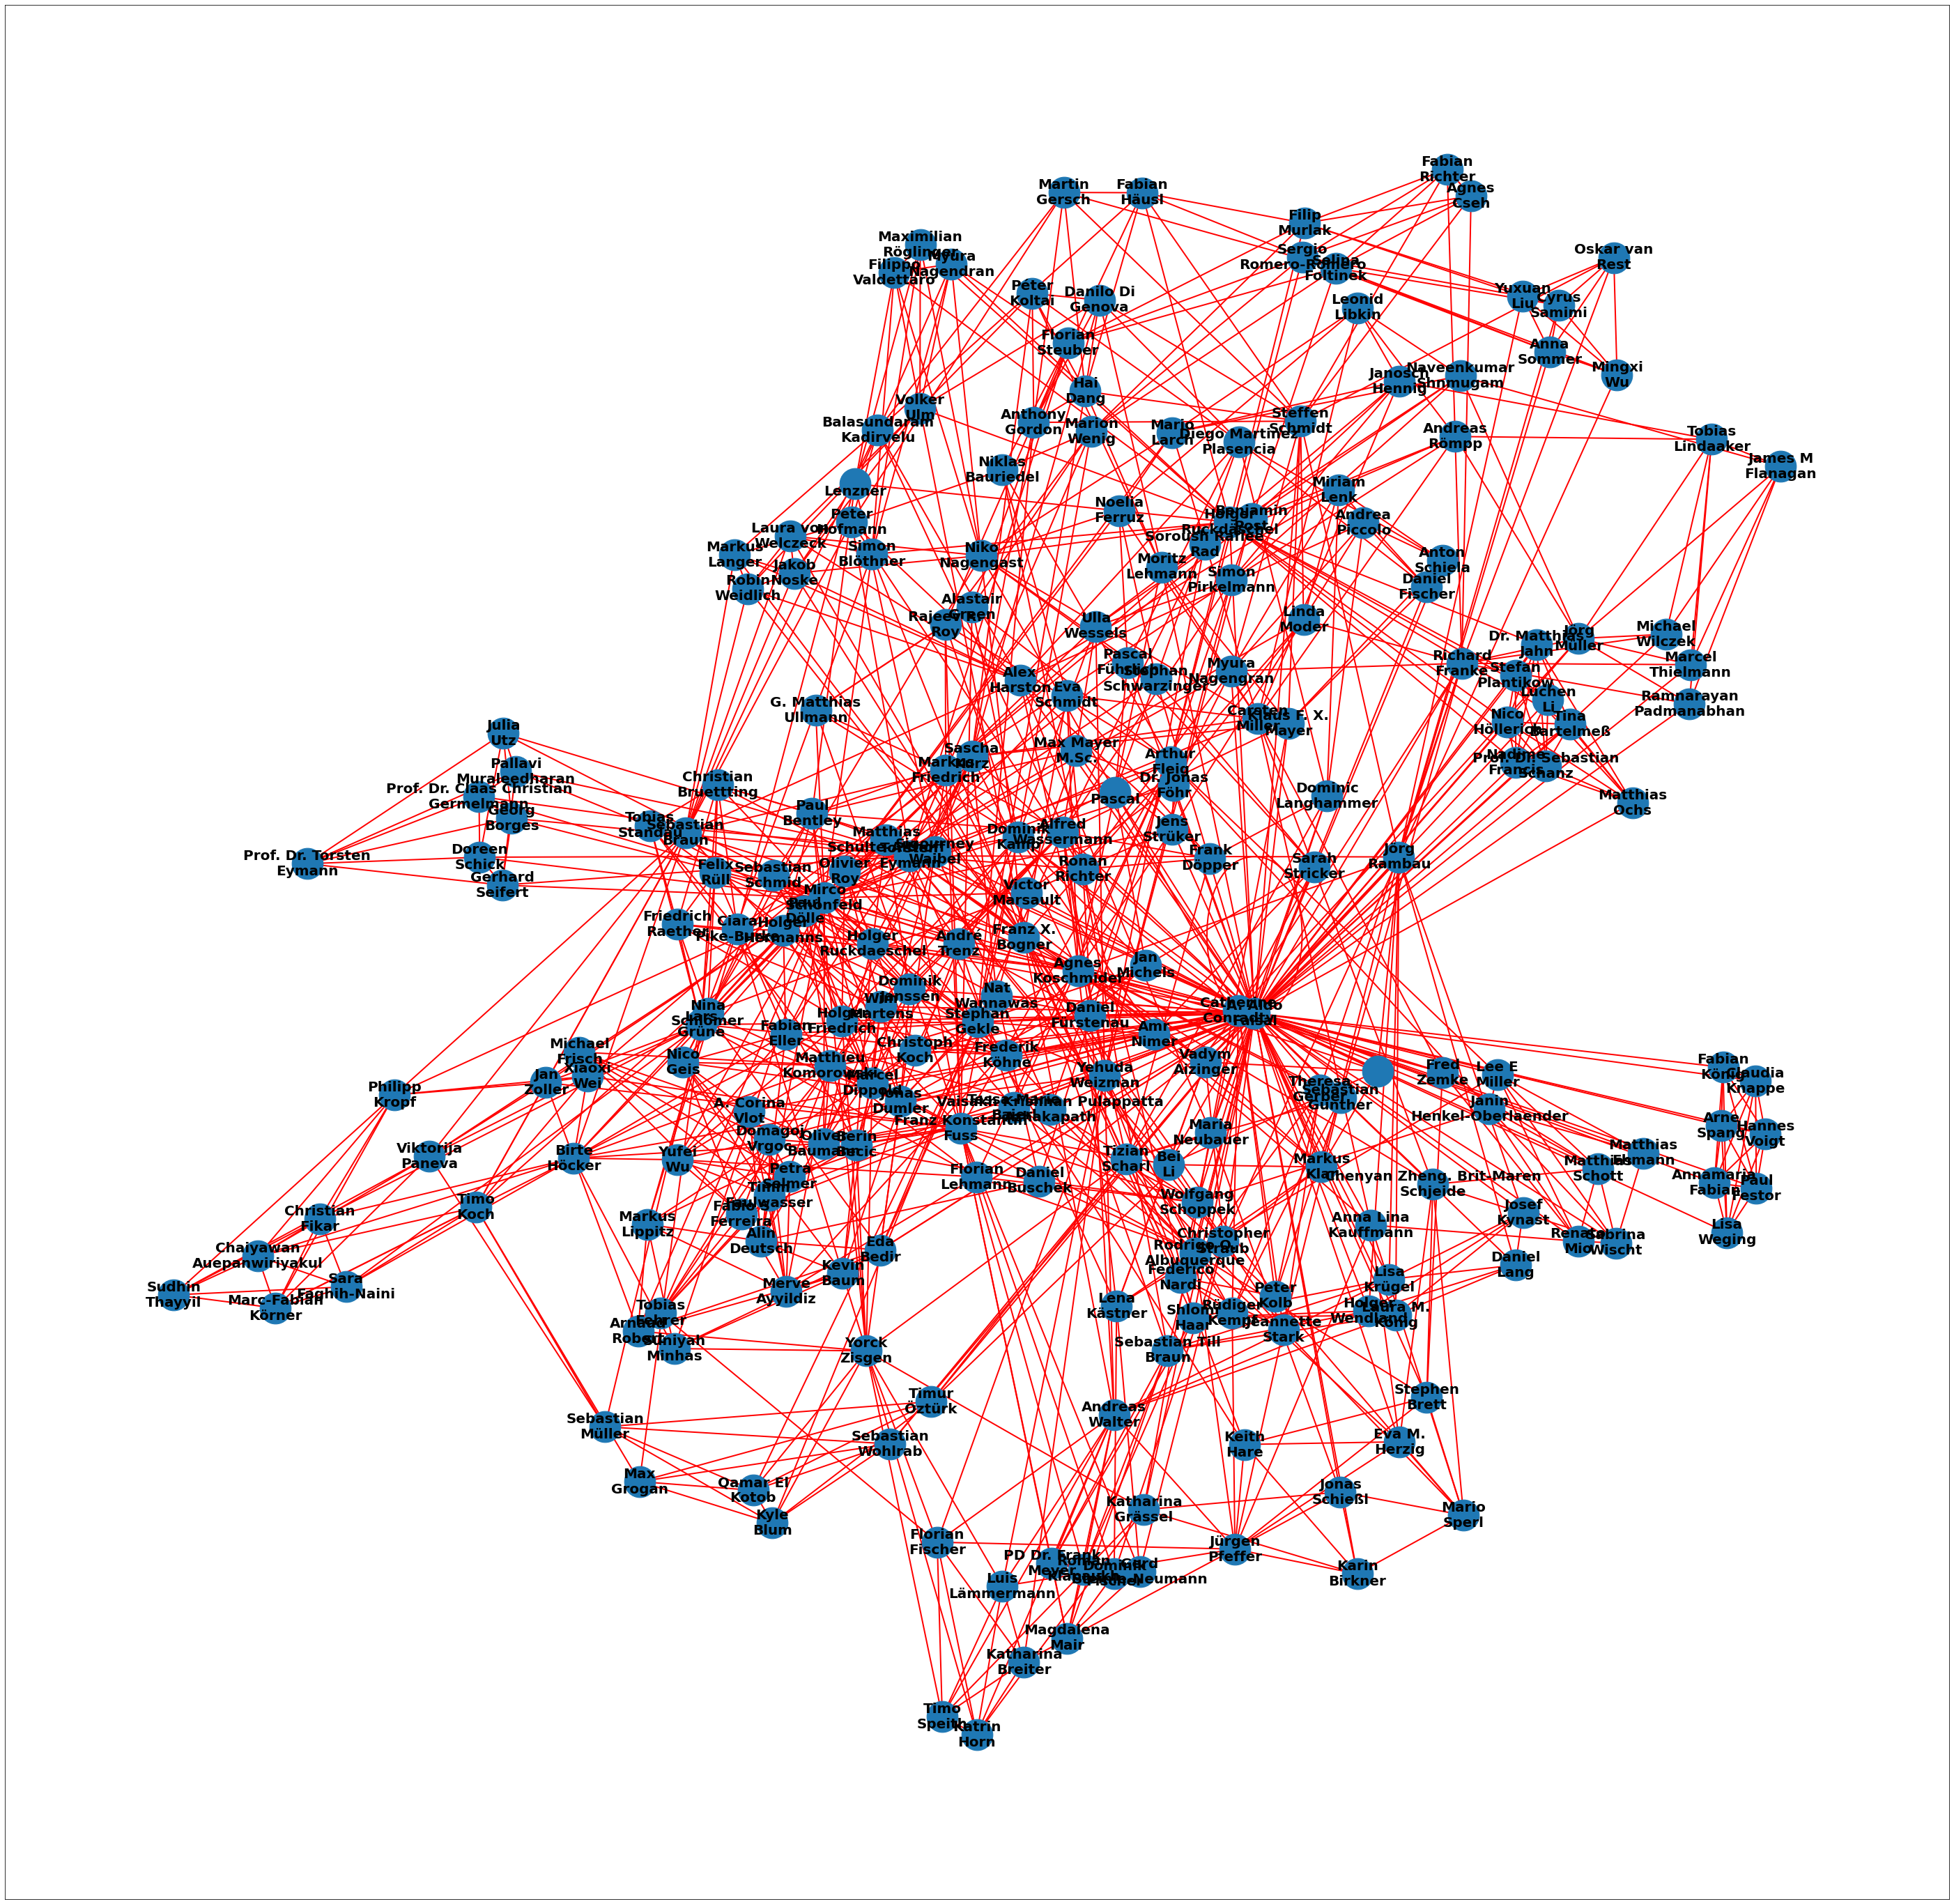

In [21]:
fig, ax = plt.subplots(figsize=(50, 50))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax, cmap=plt.get_cmap('jet'), node_size = 2000)
nx.draw_networkx_labels(G, pos, font_size=20, font_weight='bold')
nx.draw_networkx_edges(G, pos, edge_color='r', width=2)
plt.show()

In [40]:
output = []
user_ids_map = {r["real_key"]: ri for ri, r in author_mapping.items()}
for i in range(len(c)):
    match_ids = [str(user_ids_map[b_]) for b_ in np.nonzero(c[i])[0]]
    output.append({
        'user': user_ids_map[i],
        'matches': ';'.join(match_ids)
    })
output_df = pd.DataFrame(output)
output_df.to_csv("mind_match.csv", index=False)
print("Successfully save the output match to {}".format("mind_match.csv"))

Successfully save the output match to mind_match.csv


In [34]:
np.nonzero(c[3])[0]

array([ 26, 138, 139, 140, 186, 219])

In [27]:
user_ids_map

{0: 'Myura Nagendran',
 1: 'Anthony Gordon',
 2: 'A. Aldo Faisal',
 3: 'Qamar El Kotob',
 4: 'Matthieu Komorowski',
 5: 'Benjamin Post',
 6: 'Roman Klapaukh',
 7: 'Stephen Brett',
 8: 'Paul Festor',
 9: 'Myura Nagengran',
 10: 'Fabio S Ferreira',
 11: 'Suniyah Minhas',
 12: 'James M Flanagan',
 13: 'Balasundaram Kadirvelu',
 14: 'Vaisakh Krishnan Pulappatta Azhakapath',
 15: 'Pallavi Muraleedharan',
 16: 'Sudhin Thayyil',
 17: 'Yuxuan Liu',
 18: 'Ramnarayan Padmanabhan',
 19: 'Federico Nardi',
 20: 'Shlomi Haar',
 21: 'Nat Wannawas',
 22: 'Xiaoxi Wei',
 23: 'Amr Nimer',
 24: 'Alex Harston',
 25: 'Renato Mio',
 26: 'Max Grogan',
 27: 'Kyle Blum',
 28: 'Yufei Wu',
 29: 'Lee E Miller',
 30: 'Filippo Valdettaro',
 31: 'Luchen Li',
 32: 'Nico Höllerich',
 33: 'Torsten Eymann',
 34: 'Daniel Fürstenau',
 35: 'Martin Gersch',
 36: 'Anna Lina Kauffmann',
 37: 'Maria Neubauer',
 38: 'Doreen Schick',
 39: 'Nina Schlömer',
 40: 'Matthias Schulte-Althoff',
 41: 'Jeannette Stark',
 42: 'Laura von We